In [1]:
!mkdir -p /opt/model_repository/ 

In [2]:
!mkdir -p /opt/model_repository/our_new_model/ 

In [3]:
!mkdir -p /opt/model_repository/our_new_model/1/ 

In [4]:
!cp /home/ubuntu/notebooks/data/model.onnx /opt/model_repository/our_new_model/1/model.onnx 

In [5]:
!tree /opt/model_repository

/opt/model_repository
└── our_new_model
    └── 1
        └── model.onnx

2 directories, 1 file


In [6]:
import tritonclient.grpc as grpcclient
inference_server_url = "triton:8001"
triton_client = grpcclient.InferenceServerClient(url=inference_server_url)

In [7]:
model_name = "our_new_model"
print(f' Server live? {triton_client.is_server_live()}')
print(f' Server ready? {triton_client.is_server_ready()}')
print(f' Model ready? {triton_client.is_model_ready(model_name,"1")}')

 Server live? True
 Server ready? True
 Model ready? True


In [8]:
triton_client.get_model_config(model_name, "1")

config {
  name: "our_new_model"
  platform: "onnxruntime_onnx"
  backend: "onnxruntime"
  version_policy {
    latest {
      num_versions: 1
    }
  }
  input {
    name: "input"
    data_type: TYPE_FP32
    dims: 1
    dims: 3
    dims: 1024
    dims: 1024
  }
  output {
    name: "labels"
    data_type: TYPE_INT64
    dims: -1
  }
  output {
    name: "scores"
    data_type: TYPE_FP32
    dims: -1
  }
  output {
    name: "boxes"
    data_type: TYPE_FP32
    dims: -1
    dims: 4
  }
  optimization {
    input_pinned_memory {
      enable: true
    }
    output_pinned_memory {
      enable: true
    }
  }
  instance_group {
    name: "our_new_model"
    kind: KIND_GPU
    count: 1
    gpus: 0
  }
  default_model_filename: "model.onnx"
}

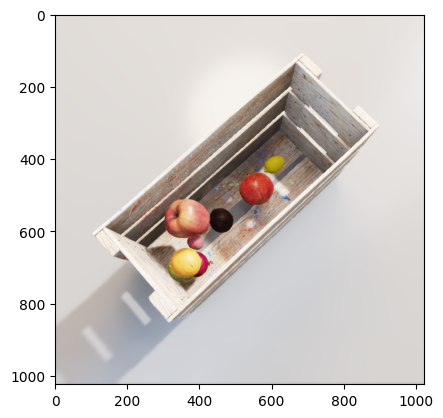

In [9]:
from tritonclient.utils import triton_to_np_dtype
import cv2
import numpy as np
from matplotlib import pyplot as plt

# load image data
target_width, target_height = 1024, 1024
image_bgr = cv2.imread("sample_image.png")
image_bgr = cv2.resize(image_bgr, (target_width, target_height))
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image = np.float32(image_rgb)

# preprocessing
image = image/255
image = np.moveaxis(image, -1, 0)  # HWC to CHW
    
image = image[np.newaxis, :] # add batch dimension
image = np.float32(image)

plt.imshow(image_rgb)

# create input
input_name = "input"
inputs = [grpcclient.InferInput(input_name, image.shape, "FP32")]
inputs[0].set_data_from_numpy(image)

output_names = ["boxes", "labels", "scores"]
outputs = [grpcclient.InferRequestedOutput(n) for n in output_names]


results = triton_client.infer(model_name, inputs, outputs=outputs)

boxes, labels, scores = [results.as_numpy(o) for o in output_names]

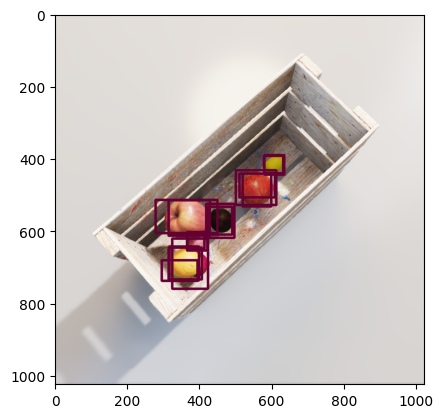

In [10]:
# annotate
annotated_image = image_bgr.copy()
            
if boxes.size > 0:  # ensure something is found
    for box, lab, scr in zip(boxes, labels, scores):

        if scr > 0.2:
            box_top_left = int(box[0]), int(box[1])
            box_bottom_right = int(box[2]), int(box[3])
            text_origin = int(box[0]), int(box[3])

            border_color = (50, 0, 100)
            text_color = (255, 255, 255)

            font_scale = 0.9
            thickness = 1

            # bounding box2
            cv2.rectangle(annotated_image, box_top_left, box_bottom_right, border_color, thickness=5,
                          lineType=cv2.LINE_8)
        
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))